In [5]:
# This Jupyter notebook is used to plot Figure 6 and Figure 8 in Model 2

# import the necessary packages
# 在开始之前需要先运行当前代码块以导入所需的包
import numpy as np
import matplotlib.pyplot as plt

## 图6代码简要讲解
下面代码可用于绘制论文中的图6，可以观察到其中内容与上一个notebook中模型一的思路完全一致（实际上也是在其基础上修改而来的），下面代码都包括以下三个部分：
1. 设置参数，并定义所需要的函数（主要涉及到季节周期中使用了$\sin$关于时间的三角函数，需要进行函数定义）
2. 欧拉法迭代，需要根据论文中的公式对原本的公式进行修改
3. 绘图，新增了背景色，用于表示不同的季节


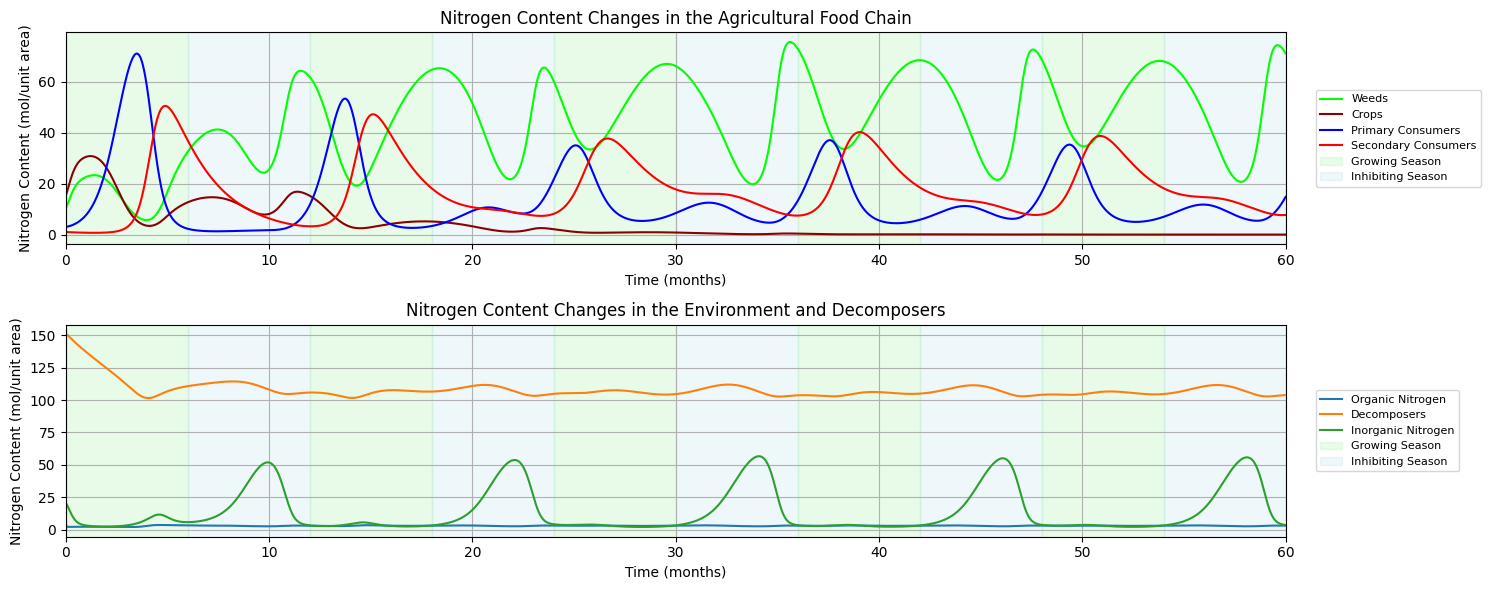

In [4]:
# Figure 6. Seasonal Cycle Factors Affecting Agricultural Ecosystems
# 考虑季节性变化对农业生态系统的影响

#########################
## 1. Parameters 设置参数
#########################

# Parameters for seasonal variation
T = 12  # period (12 months)，新增参数
phi = 0  # phase shift，新增参数
r_w_0 = 0.11  # baseline growth rate of weeds
r_w_season = 0.11  # seasonal amplitude for weeds
r_c_0 = 0.1  # baseline growth rate of crops
r_c_season = 0.1  # seasonal amplitude for crops
gamma_1_0 = 0.06  # baseline death rate for primary consumers 
gamma_1_season = 0.2  # seasonal amplitude for primary consumer death rate
gamma_w_0 = 0.2  # baseline death rate for weeds
gamma_w_season = 0.15  # seasonal amplitude for weed death rate
gamma_c_0 = 0.2  # baseline death rate for crops
gamma_c_season = 0.15  # seasonal amplitude for crop death rate

# Other parameters remain the same as before
#gamma_w = 0.02  # death rate of weeds
#gamma_c = 0.06  # death rate of crops
gamma = np.array([gamma_1_0, 0.5])  # initial death rates for consumers
alpha_w1 = 0.025
alpha_c1 = 0.03
alpha = np.array([0.05])
beta_w1 = 0.02
beta_c1 = 0.025
beta = np.array([0.04])
c_wc = 0.001
c_cw = 0.0015
d = 0.2
delta = 0.12
gamma_D = 0.35

# Time parameters
t_max = 60
dt = 0.01
t = np.arange(0, t_max, dt)
n_steps = len(t)

# Initialize arrays (same as before)
N_w = np.zeros(n_steps)
N_c = np.zeros(n_steps)
N = np.zeros((2, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)

# Initial conditions (same as before)
N_w[0] = 10
N_c[0] = 15
N[:, 0] = [3, 1]
N_org[0] = 5
N_D[0] = 150
N_inorg[0] = 20


# Define time-varying parameter functions
# 这里是新增的部分，定义季节性变化的参数函数

def r_w(t):
    return r_w_0 + r_w_season * np.sin(2*np.pi*t/T + phi)

def r_c(t):
    return r_c_0 + r_c_season * np.sin(2*np.pi*t/T + phi)

def gamma_w(t):
    return gamma_w_0 + gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_c(t):
    return gamma_c_0 + gamma_c_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_1(t):
    return gamma_1_0 + gamma_1_season * np.sin(2*np.pi*t/T + phi + np.pi)


#########################
## 2. Simulation 使用欧拉法进行数值模拟
#########################
# 根据论文中建立的公式修改每一步迭代的代码，在其中加入季节性变化的参数

# Modified Euler method with time-varying parameters
for i in range(n_steps-1):
    # Update time-varying parameters
    current_gamma = np.array([gamma_1(t[i]), gamma[1]])
    
    # Producers (Weeds and Crops)
    N_w[i+1] = N_w[i] + dt * (r_w(t[i]) * N_inorg[i] * N_w[i] - gamma_w(t[i]) * N_w[i] - 
                              alpha_w1 * N_w[i] * N[0,i] - c_cw * N_c[i] * N_w[i])
    
    N_c[i+1] = N_c[i] + dt * (r_c(t[i]) * N_inorg[i] * N_c[i] - gamma_c(t[i]) * N_c[i] - 
                              alpha_c1 * N_c[i] * N[0,i] - c_wc * N_w[i] * N_c[i])
    
    # Primary Consumer (with seasonal death rate)
    N[0,i+1] = N[0,i] + dt * (beta_w1 * N_w[i] * N[0,i] + beta_c1 * N_c[i] * N[0,i] - 
                              current_gamma[0] * N[0,i] - alpha[0] * N[0,i] * N[1,i])
    
    # Secondary Consumer
    N[1,i+1] = N[1,i] + dt * (beta[0] * N[0,i] * N[1,i] - current_gamma[1] * N[1,i])

    # Organic nitrogen
    producer_mortality = gamma_w(t[i])* N_w[i] + gamma_c(t[i]) * N_c[i]
    consumer_mortality = sum(current_gamma[j] * N[j,i] for j in range(2))
    unconsumed_prey = (alpha_w1 - beta_w1) * N_w[i] * N[0,i] + (alpha_c1 - beta_c1) * N_c[i] * N[0,i] + \
                     (alpha[0] - beta[0]) * N[0,i] * N[1,i]
    competition_loss = (c_wc + c_cw) * N_w[i] * N_c[i]
    
    N_org[i+1] = N_org[i] + dt * (unconsumed_prey + producer_mortality + consumer_mortality + 
                                  competition_loss + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers and Inorganic nitrogen (same as before)
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - 
                                      r_w(t[i]) * N_inorg[i] * N_w[i] - r_c(t[i]) * N_inorg[i] * N_c[i])

#########################
## 3. Plotting 绘图
#########################

# Plot results (same plotting code as before)
plt.figure(figsize=(15, 6))
#plt.subplots_adjust(right=0.85)  # Make room for legend

# Set figure-level parameter
plt.subplot(2, 1, 1)
plt.xlim(0, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_w, label='Weeds', color='lime')        
plt.plot(t, N_c, label='Crops', color='darkred')     
plt.plot(t, N[0], label='Primary Consumers', color='blue')
plt.plot(t, N[1], label='Secondary Consumers', color='red')
# Add background shading for all periods
for i in range(int(t_max/T)):
    # First half of the period
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, label='Growing Season' if i==0 else "")
    # Second half of the period
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, label='Inhibiting Season' if i==0 else "")
plt.title('Nitrogen Content Changes in the Agricultural Food Chain')
plt.xlabel('Time (months)')
plt.ylabel('Nitrogen Content (mol/unit area)')
plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.02, 0.5))  # Position legend outside plot
plt.grid(True)

plt.subplot(2, 1, 2)
plt.xlim(0, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_org, label='Organic Nitrogen')
plt.plot(t, N_D, label='Decomposers')
plt.plot(t, N_inorg, label='Inorganic Nitrogen')
for i in range(int(t_max/T)):
    # First half of the period
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, label='Growing Season' if i==0 else "")
    # Second half of the period
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, label='Inhibiting Season' if i==0 else "")
plt.title('Nitrogen Content Changes in the Environment and Decomposers')
plt.xlabel('Time (months)')
plt.ylabel('Nitrogen Content (mol/unit area)')
plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.02, 0.5))  # Position legend outside plot
plt.grid(True)

plt.tight_layout()
plt.show()

## 图8绘制代码简要讲解
- 实现了在考虑季节性变化的基础上，加入农业活动（播种、收割）、化学品（除草剂、杀虫剂）和肥料的影响
- 在算法实现层面，其实就是在欧拉法的迭代过程中，按时序加入农业活动、化学品和肥料对每个变量的影响即可
- 实现思路与之前的代码都一样：
  1. 先设置参数并定义函数，
  2. 使用欧拉法迭代（每一步迭代过程中根据公式引入新的变化）
  3. 绘制图像（不过为了图片的多样性，这次的图与之前不太一样）

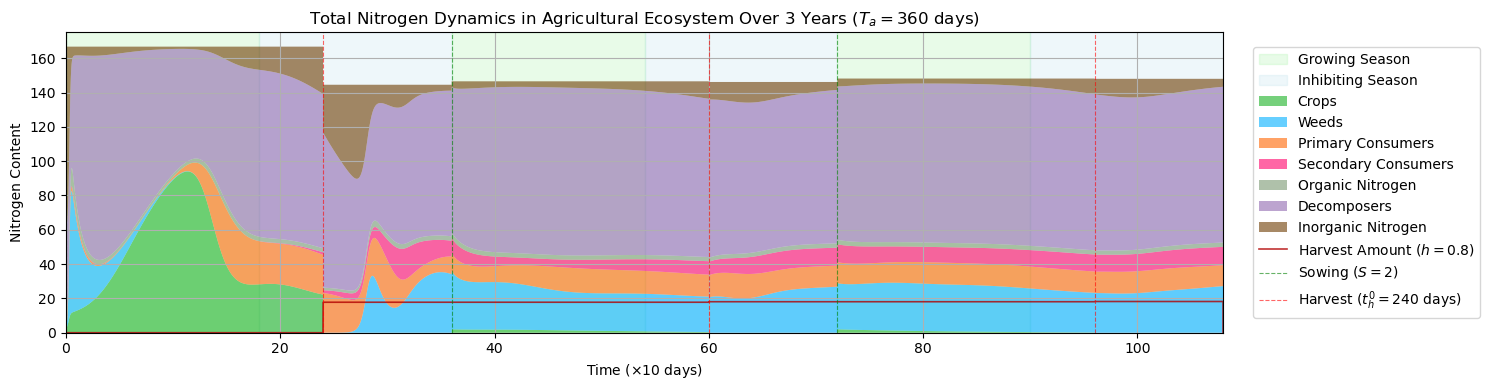

In [ ]:
# Figure 8: Agricultural ecosystem without chemicals and fertilizers

#########################
## 1. Parameters 设置参数
#########################

# New parameters 新引入的参数
# Agricultural parameters
T_a = 36  # agricultural cycle
t_h_0 = 24  # initial harvest time
t_s_0 = 0  # initial planting time
S = 2     # seeding amount
h = 0.8    # harvest coefficient

# Chemical parameters
gamma_w_chem = 1.5    # herbicide effect
lambda_w = 0.05        # herbicide decay rate
T_w = 1000             # herbicide application period 除草周期
gamma_1_chem = 1.5   # pesticide effect
lambda_1 = 0.05        # pesticide decay rate 
T_1 = 1000             # pesticide application period 杀虫周期

# Fertilizer parameters
F = 5               # fertilizer amount
T_f = 1000           # fertilizer period
t_f_0 = 0           # initial fertilizer time

# Parameters for seasonal variation
T = 36  # period (12 months)
phi = 0  # phase shift
r_w_0 = 0.15  # baseline growth rate of weeds
r_w_season = 0.08  # seasonal amplitude for weeds
r_c_0 = 0.05  # baseline growth rate of crops
r_c_season = 0.034  # seasonal amplitude for crops
gamma_1_0 = 0.02  # baseline death rate for primary consumers
gamma_1_season = 0.067  # seasonal amplitude for primary consumer death rate
gamma_w_0 = 0.067  # baseline death rate for weeds
gamma_w_season = 0.05  # seasonal amplitude for weed death rate
gamma_c_0 = 0.03  # baseline death rate for crops
gamma_c_season = 0.015  # seasonal amplitude for crop death rate

# Other parameters remain the same as before
gamma = np.array([gamma_1_0, 0.5])  # initial death rates for consumers
alpha_w1 = 0.05
alpha_c1 = 0.025
alpha = np.array([0.05])
beta_w1 = 0.02
beta_c1 = 0.02
beta = np.array([0.04])
c_wc = 0.0002
c_cw = 0.0003
d = 0.2
delta = 0.12
gamma_D = 0.30


# Time parameters
t_max = 108
dt = 0.002
t = np.arange(0, t_max, dt)
n_steps = len(t)

# Initialize arrays (same as before)
N_w = np.zeros(n_steps)
N_c = np.zeros(n_steps)
N = np.zeros((2, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)
# Initialize arrays
harvest = np.zeros(n_steps)  # Store harvest amount at each time point
last_harvest_time = -float('inf')  # Track the last harvest time
have_harvest = np.zeros(n_steps)  # Store harvest at each time point

# Initial conditions (same as before)
N_w[0] = 0.8
N_c[0] = 2
N[:, 0] = [3, 1]
N_org[0] = 5
N_D[0] = 50
N_inorg[0] = 100

# Define time-varying parameter functions
def r_w(t):
    return r_w_0 + r_w_season * np.sin(2*np.pi*t/T + phi)

def r_c(t):
    return r_c_0 + r_c_season * np.sin(2*np.pi*t/T + phi)

def gamma_c(t):
    return gamma_c_0 + gamma_c_season * np.sin(2*np.pi*t/T + phi + np.pi)


def gamma_w(t):
    n_w = int(t/T_w)  # Current herbicide cycle
    if(N_c[i] > 0):
        return (gamma_w_0 + 
                gamma_w_chem * np.exp(-lambda_w * (t - T_w*n_w)) +
                gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi))
    else:
        return gamma_w_0 + gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_1(t):
    n_1 = int(t/T_1)  # Current pesticide cycle
    if(N_c[i] > 0):
        return (gamma_1_0 + 
            gamma_1_chem * np.exp(-lambda_1 * (t - T_1*n_1)) +
            gamma_1_season * np.sin(2*np.pi*t/T + phi))
    else:
        return gamma_1_0 + gamma_1_season * np.sin(2*np.pi*t/T + phi)


#########################
## 2. Modified simulation loop 使用欧拉法迭代求解
#########################
# 可以观察一下其中不同氮含量的迭代公式与之前的区别

for i in range(n_steps-1):
    n_a = int(t[i]/T_a)  # Current agricultural cycle

    # Update time-varying parameters
    current_gamma = np.array([gamma_1(t[i]), gamma[1]])
    
    # Producers (Weeds and Crops)
    N_w[i+1] = N_w[i] + dt * (r_w(t[i]) * N_inorg[i] * N_w[i] - gamma_w(t[i]) * N_w[i] - 
                              alpha_w1 * N_w[i] * N[0,i] - c_cw * N_c[i] * N_w[i])
    
    N_c[i+1] = N_c[i] + dt * (r_c(t[i]) * N_inorg[i] * N_c[i] - gamma_c(t[i]) * N_c[i] - 
                              alpha_c1 * N_c[i] * N[0,i] - c_wc * N_w[i] * N_c[i])
    
    # Primary Consumer (with seasonal death rate)
    N[0,i+1] = N[0,i] + dt * (beta_w1 * N_w[i] * N[0,i] + beta_c1 * N_c[i] * N[0,i] - 
                              current_gamma[0] * N[0,i] - alpha[0] * N[0,i] * N[1,i])
    
    # Secondary Consumer
    N[1,i+1] = N[1,i] + dt * (beta[0] * N[0,i] * N[1,i] - current_gamma[1] * N[1,i])

    # Organic nitrogen
    producer_mortality = gamma_w(t[i])* N_w[i] + gamma_c(t[i]) * N_c[i]
    consumer_mortality = sum(current_gamma[j] * N[j,i] for j in range(2))
    unconsumed_prey = (alpha_w1 - beta_w1) * N_w[i] * N[0,i] + (alpha_c1 - beta_c1) * N_c[i] * N[0,i] + \
                     (alpha[0] - beta[0]) * N[0,i] * N[1,i]
    competition_loss = (c_wc + c_cw) * N_w[i] * N_c[i]
    
    N_org[i+1] = N_org[i] + dt * (unconsumed_prey + producer_mortality + consumer_mortality + 
                                  competition_loss + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers and Inorganic nitrogen (same as before)
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - 
                                      r_w(t[i]) * N_inorg[i] * N_w[i] - r_c(t[i]) * N_inorg[i] * N_c[i])
    
 # Add fertilizer
    n_f = int(t[i]/T_f)
    if abs(t[i] - (t_f_0 + T_f*n_f)) < dt:
        if (N_c[i] > 0):
            N_inorg[i+1] += F


    # Harvest time
    if abs(t[i] - (t_h_0 + T_a*n_a)) < dt and N_c[i] > 0:
        harvest[i] = h * N_c[i+1] + harvest[i-1] # Store the harvest amount
        N_c[i+1] = 0  # Remove crops after harvest
    else:
        harvest[i] = harvest[i-1]  # Maintain harvest amount after harvest time

    # Planting time with smooth transition
    if (abs(t[i] - (t_s_0 + T_a*n_a)) < dt):
        # Only plant if there are no crops
        if N_c[i] < 0.1:  # Small threshold to check if field is empty
            N_c[i+1] = S
        else:
            N_c[i+1] = N_c[i]  # Maintain current crop level if already planted
        

#########################
## 3. Plotting 绘图
#########################

# Plot all components as nitrogen content in a single stacked plot
plt.figure(figsize=(15, 4))
plt.xlim(0, t_max)

# Add seasonal background
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, 
                label='Growing Season' if i==0 else "")
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, 
                label='Inhibiting Season' if i==0 else "")


# Create stackplot for all nitrogen components
all_nitrogen_components = {
    'Crops': N_c,
    'Weeds': N_w,
    'Primary Consumers': N[0],
    'Secondary Consumers': N[1],

    'Organic Nitrogen': N_org,
    'Decomposers': N_D,
    'Inorganic Nitrogen': N_inorg,
}

colors = ['#1ab223', '#00b0ff', '#ff6500', '#ff006a', '#7a9972', '#9068af', '#6d3b00']

plt.stackplot(t, all_nitrogen_components.values(),
             labels=all_nitrogen_components.keys(),
             colors=colors,
             alpha=0.6)

# Plot harvest separately as it's a cumulative measure
plt.plot(t, harvest, label=r'Harvest Amount ($h = 0.8$)', color='#b10000', alpha=0.8, linewidth=1.2)


# Add planting and harvest markers with thinner lines
for i in range(int(t_max/T_a)):
    plt.axvline(x=t_s_0 + i*T_a, color='green', linestyle='--', alpha=0.6, linewidth=0.8,
                label=r'Sowing ($S = 2$)' if i==0 else "")
    plt.axvline(x=t_h_0 + i*T_a, color='red', linestyle='--', alpha=0.6, linewidth=0.8,
                label=r'Harvest ($t_h^{0}=240$ days)' if i==0 else "")

plt.rcParams['mathtext.fontset'] = 'dejavusans'
# Plot and set title with mathtext
# plt.title(r'Total Nitrogen Distribution in Agricultural System During 3 Years  $T_a$=360 days)')
plt.title(r'Total Nitrogen Dynamics in Agricultural Ecosystem Over 3 Years ($T_a = 360$ days)')

plt.xlabel(r'Time ($\times 10$ days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()
